<a href="https://colab.research.google.com/github/yasinnerten/graduation-thesis/blob/main/Metro_Istanbul_Usage_Prediciton_sona_%C3%A7ok_yak%C4%B1n_bi_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Ortamın hazır hale getirilmesi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from PIL import Image

# For external libraries, use pip in your setup environment, not directly in the script
# !pip install sktime

# If you need to interact with tar files or make web requests, you might use:
import tarfile
import requests
from io import BytesIO

print('Ortam Hazır')

Ortam Hazır


In [2]:
def load_data(url):
  url = url_august
  response = requests.get(url_august)

  with tarfile.open(fileobj=BytesIO(response.content), mode='r:xz') as tar:

      csv_file_name = tar.getnames()[0]
      data_august = tar.extractfile(csv_file_name)

      # Read the extracted file into a pandas DataFrame
      data = pd.read_csv(data_august)
  return data

### Verinin Yüklenmesi

In [3]:
# Load the data
#url_github = 'https://raw.githubusercontent.com/yasinnerten/graduation-thesis/main/m2_tam_bilet_41k.csv'
#data_github = pd.read_csv(url_github)

#url_september = 'https://data.ibb.gov.tr/dataset/a6855ce7-4092-40a5-82b5-34cf3c7e36e3/resource/4546fb79-e598-4dc7-888b-626361110e37/download/hourly_transportation_202409.csv'

url_august = 'https://github.com/yasinnerten/graduation-thesis/raw/refs/heads/main/hourly_transportation_202408.tar.xz'
data = load_data(url_august)
data.head()

,transition_date,transition_hour,transport_type_id,road_type,line,transfer_type,number_of_passage,number_of_passenger,product_kind,transaction_type_desc,town,line_name,station_poi_desc_cd
0,2024-08-01,0,1,OTOYOL,MESCIDI SELAM-ARNAVUTKOY-ISTANBUL HAVA LIMANI,Normal,1,1,TAM,Tam Kontur,ATASEHIR,H-6,NaN
1,2024-08-01,0,1,OTOYOL,MECIDIYEKOY-ISTANBUL HAVALIMANI,Normal,1,1,INDIRIMLI1,Indirimli Abonman,ATASEHIR,H-2,NaN
2,2024-08-01,0,1,OTOYOL,KOC UNV. RUMELIFENER KAMPUSU - TAKSIM,Normal,3,3,TAM,Tam Kontur,ATASEHIR,40,NaN
3,2024-08-01,0,1,OTOYOL,HACI OSMAN METRO - RUMELI FENERI,Aktarma,1,1,TAM,Tam Aktarma,ATASEHIR,150,NaN
4,2024-08-01,0,1,OTOYOL,USKUDAR-GUZELTEPE-UMRANIYE DEVLET HASTANESI,Normal,3,3,TAM,Tam Kontur,BAKIRKOY,15B,NaN


### Verinin Hazırlanması

In [23]:
veri_filtreleme = data[
    (data['line_name'] == "M2") &
    (data['transport_type_id'] == 2)
]
veri_filtreleme
#&(data['station_poi_desc_cd'] == "YENIKAPI GUNEY")

,transition_date,transition_hour,transport_type_id,road_type,line,transfer_type,number_of_passage,number_of_passenger,product_kind,transaction_type_desc,town,line_name,station_poi_desc_cd
28,2024-08-01,0,2,RAYLI,YENIKAPI - HACIOSMAN,Normal,1,1,UCRETSIZ,Ucretsiz,FATIH,M2,YENIKAPI GUNEY
29,2024-08-01,0,2,RAYLI,YENIKAPI - HACIOSMAN,Normal,1,1,TAM,Tam Kontur,FATIH,M2,YENIKAPI KUZEY
35,2024-08-01,0,2,RAYLI,YENIKAPI - HACIOSMAN,Normal,15,15,INDIRIMLI1,Indirimli Abonman,FATIH,M2,YENIKAPI GUNEY
70,2024-08-01,0,2,RAYLI,YENIKAPI - HACIOSMAN,Normal,5,4,TAM,TekliBilet Tarifeli,BEYOGLU,M2,TAKSIM GUNEY
119,2024-08-01,0,2,RAYLI,YENIKAPI - HACIOSMAN,Normal,10,10,INDIRIMLI1,Indirimli Kontur,BEYOGLU,M2,SISHANE KUZEY
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2953988,2024-08-31,23,2,RAYLI,YENIKAPI - HACIOSMAN,Normal,5,3,UCRETSIZ,Ucretsiz,BEYOGLU,M2,SISHANE KUZEY
2953999,2024-08-31,23,2,RAYLI,YENIKAPI - HACIOSMAN,Normal,6,6,UCRETSIZ,Ucretsiz,SISLI,M2,LEVENT 2 KUZEY
2954012,2024-08-31,23,2,RAYLI,YENIKAPI - HACIOSMAN,Aktarma,1,1,UCRETSIZ,Tam Aktarma,BEYOGLU,M2,SISHANE KUZEY
2954034,2024-08-31,23,2,RAYLI,YENIKAPI - HACIOSMAN,Aktarma,53,53,INDIRIMLI1,Indirimli Aktarma,SISLI,M2,SISLI 2 KUZEY


In [24]:
veri_temizleme = veri_filtreleme.drop(columns=[
    'line_name', 'transport_type_id', 'product_kind',
    'transaction_type_desc', 'number_of_passage', 'town',
    'line', 'transfer_type', 'road_type'
], errors='ignore')
veri_temizleme

,transition_date,transition_hour,number_of_passenger,station_poi_desc_cd
28,2024-08-01,0,1,YENIKAPI GUNEY
29,2024-08-01,0,1,YENIKAPI KUZEY
35,2024-08-01,0,15,YENIKAPI GUNEY
70,2024-08-01,0,4,TAKSIM GUNEY
119,2024-08-01,0,10,SISHANE KUZEY
...,...,...,...,...
2953988,2024-08-31,23,3,SISHANE KUZEY
2953999,2024-08-31,23,6,LEVENT 2 KUZEY
2954012,2024-08-31,23,1,SISHANE KUZEY
2954034,2024-08-31,23,53,SISLI 2 KUZEY


In [25]:
grouped_data = veri_temizleme.groupby(['transition_date', 'transition_hour','station_poi_desc_cd'], as_index=False)['number_of_passenger'].sum()
grouped_data

,transition_date,transition_hour,station_poi_desc_cd,number_of_passenger
0,2024-08-01,0,4 LEVENT 2 GUNEY,12
1,2024-08-01,0,4 LEVENT KUZEY,25
2,2024-08-01,0,ATATURK OTO SANAYI GUNEY,3
3,2024-08-01,0,ATATURK OTO SANAYI KUZEY,2
4,2024-08-01,0,DARUSSAFAKA,2
...,...,...,...,...
3977,2024-08-31,23,TAKSIM GUNEY,1474
3978,2024-08-31,23,VEZNECILER GUNEY,136
3979,2024-08-31,23,VEZNECILER KUZEY,81
3980,2024-08-31,23,YENIKAPI GUNEY,348


In [27]:
# Haftanın gününü ekleme
grouped_data['transition_date'] = pd.to_datetime(grouped_data['transition_date'])
grouped_data['day_of_week'] = pd.to_datetime(grouped_data['transition_date']).dt.dayofweek

# Zaman serisi verisi: transition_date ve transition_hour'a göre sıralama
grouped_data = grouped_data.sort_values(by=['transition_date', 'transition_hour']).reset_index(drop=True)
grouped_data

,transition_date,transition_hour,station_poi_desc_cd,number_of_passenger,day_of_week
0,2024-08-01,0,4 LEVENT 2 GUNEY,12,3
1,2024-08-01,0,4 LEVENT KUZEY,25,3
2,2024-08-01,0,ATATURK OTO SANAYI GUNEY,3,3
3,2024-08-01,0,ATATURK OTO SANAYI KUZEY,2,3
4,2024-08-01,0,DARUSSAFAKA,2,3
...,...,...,...,...,...
3977,2024-08-31,23,TAKSIM GUNEY,1474,5
3978,2024-08-31,23,VEZNECILER GUNEY,136,5
3979,2024-08-31,23,VEZNECILER KUZEY,81,5
3980,2024-08-31,23,YENIKAPI GUNEY,348,5


In [28]:
# One-hot encoding uygulama
column_transformer = ColumnTransformer(
    transformers=[
        ('day_of_week_ohe', OneHotEncoder(), ['day_of_week']),
        ('station_ohe', OneHotEncoder(), ['station_poi_desc_cd'])
    ],
    remainder='passthrough'
)
features = column_transformer.fit_transform(grouped_data[['transition_hour', 'day_of_week', 'station_poi_desc_cd']]).toarray()  # Dense formata dönüştür

# Hedef değişkeni ayır
target = grouped_data['number_of_passenger'].values.reshape(-1, 1)

# Hedef değişkeni normalleştir
scaler = MinMaxScaler(feature_range=(0, 1))
target = scaler.fit_transform(target)

In [29]:
def create_dataset(features, target, time_step=1):
    X, y = [], []
    for i in range(len(target) - time_step - 1):
        a = features[i:(i + time_step), :]
        X.append(a)
        y.append(target[i + time_step, 0])
    return np.array(X), np.array(y)


timestep seçimi

In [30]:
time_step = 12 ### HYPERPARAMETER: modelde kullanılacak örnek sayısı: (N - time_step - 1)

X, y = create_dataset(features, target, time_step)
print(X.shape)
print(y.shape)

(3969, 12, 37)
(3969,)


In [31]:
if len(X.shape) == 2:
    X = X.reshape((X.shape[0], X.shape[1], 1))

In [32]:
# Veriyi train-validation-test olarak ayır
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [33]:
y_test, y_train, y_val

(array([3.21280300e-01, 1.53073524e-01, 4.53997589e-02, 4.78103656e-02,
        0.00000000e+00, 1.18387572e-01, 1.50261149e-01, 5.59796438e-02,
        9.37458149e-04, 1.86152404e-02, 1.27226463e-02, 4.04446230e-02,
        2.54586849e-01, 3.72304808e-02, 3.26771126e-02, 1.33922593e-03,
        1.03254319e-01, 5.22298112e-03, 9.37458149e-04, 9.37458149e-04,
        8.12910138e-02, 1.00441945e-02, 1.33922593e-04, 1.47314852e-02,
        7.92821749e-02, 1.91509308e-02, 1.03120396e-02, 3.95071649e-02,
        1.04191777e-01, 6.69612964e-04, 1.90170082e-01, 2.57399223e-01,
        1.23208785e-02, 1.95526985e-02, 4.95513593e-02, 2.66505960e-02,
        6.34793090e-02, 2.71862863e-02, 4.74085978e-02, 4.15160037e-03,
        2.67845185e-04, 1.17182269e-01, 0.00000000e+00, 3.73644034e-02,
        7.05772064e-02, 3.28110352e-02, 9.91027186e-03, 7.64698005e-02,
        4.27213071e-02, 1.05798848e-02, 3.50877193e-02, 8.02196331e-02,
        3.37484934e-02, 3.09361189e-02, 4.12481586e-02, 5.423865

### Model oluşturma ve hyperparameter optimizasyonu

In [34]:
# Hyperparameter settings
epochs = 50
batch_size = 32
learning_rate = 0.001
loss_function = 'mse'
activation_function = 'relu'

In [35]:
model = Sequential()

model.add(GRU(50, return_sequences=True, activation=activation_function, input_shape=(time_step, X.shape[2])))  # Daha karmaşık model (GRU)
model.add(Dropout(0.3))
model.add(GRU(50, return_sequences=True, activation=activation_function))
model.add(Dropout(0.3))
model.add(LSTM(50, return_sequences=False, activation=activation_function))
model.add(Dropout(0.3))
model.add(Dense(1))
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss_function)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, 12, 50)              │          13,350 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 12, 50)              │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 12, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,901 (191.02 KB)

 Trainable params: 48,901 (191.02 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Checkpoint ve EarlyStopping ayarları
checkpoint = ModelCheckpoint('best_model.h5.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

# Modeli eğit
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[checkpoint, early_stop])

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0364
Epoch 1: val_loss improved from inf to 0.00607, saving model to best_model.h5.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0361 - val_loss: 0.0061
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0065
Epoch 2: val_loss did not improve from 0.00607
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0080
Epoch 3: val_loss did not improve from 0.00607
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0079 - val_loss: 0.0064
Epoch 4/50
85/87 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0061
Epoch 4: val_loss improved from 0.00607 to 0.00538, saving model to best_model.h5.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0061 - val_loss: 0.0054
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0056
Epoch 5: val_loss improved from 0.00538 to 0.00418, saving model to best_model.h5.keras
87/87 ━━━━━━━━━━━━━━

### Model performansı

In [37]:
# Test verisi ile tahmin yap ve performansı ölç
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# RMSE hesapla
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Test RMSE: {rmse}')


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Test RMSE: 281.81407507873394


In [38]:

# Test ve tahmin sonuçlarını saatlik karşılaştırmalı tablo olarak göster
comparison_df = pd.DataFrame({'Gerçek Değerler': y_test.flatten(), 'Tahmin Değerleri': y_pred.flatten()})
print(comparison_df)


     Gerçek Değerler  Tahmin Değerleri
0             2400.0       1897.623413
1             1144.0        893.671082
2              340.0        117.464691
3              358.0        339.363647
4                1.0         27.079531
..               ...               ...
591             11.0         49.774296
592           1268.0       1309.633179
593           2670.0       2249.380371
594           1278.0        932.305237
595             32.0        111.608963

[596 rows x 2 columns]


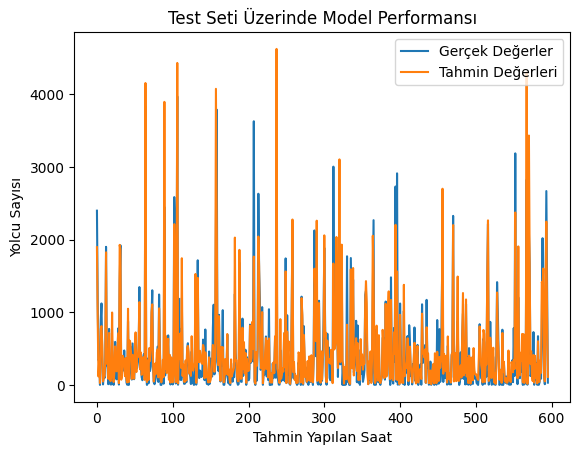

In [68]:
plt.plot(y_test, label='Gerçek Değerler', linestyle='-', marker='none')
plt.plot(y_pred, label='Tahmin Değerleri', linestyle='-', marker='none')
plt.xlabel('Tahmin Yapılan Saat')
plt.ylabel('Yolcu Sayısı')
plt.title('Test Seti Üzerinde Model Performansı')
plt.legend()
plt.show()

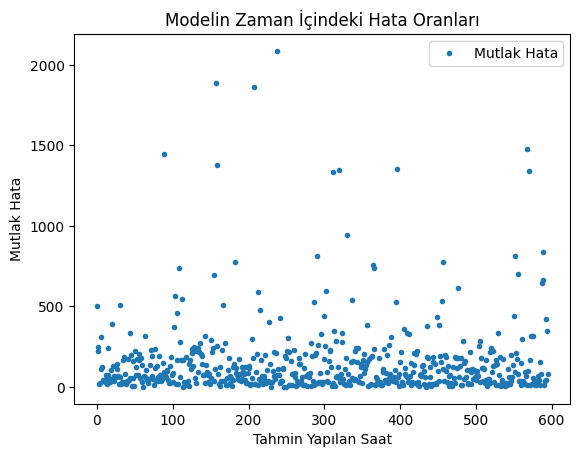

In [70]:

# Gerçek değerler (y_test) ve tahmin değerleri (y_pred) arasındaki mutlak farkları hesapla
errors = np.abs(y_test - y_pred)

# Hata oranlarını lineer bir çizgi grafiği olarak çiz
plt.plot(errors, label='Mutlak Hata', linestyle='', marker=".")
plt.xlabel('Tahmin Yapılan Saat')
plt.ylabel('Mutlak Hata')
plt.title('Modelin Zaman İçindeki Hata Oranları')
plt.legend()
plt.show()

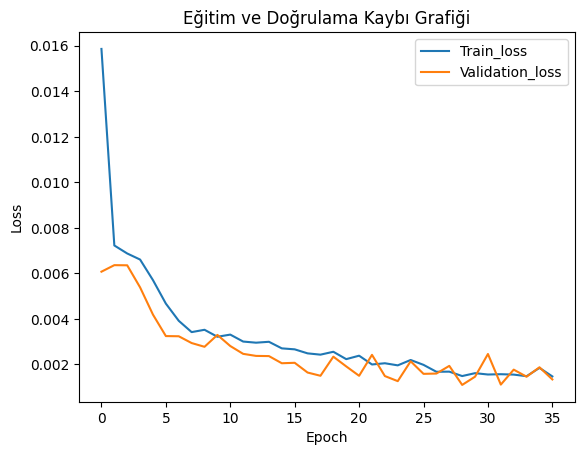

In [40]:
# Eğitim ve doğrulama kaybını görselleştir
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label='Validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Eğitim ve Doğrulama Kaybı Grafiği')
plt.legend()
plt.show()

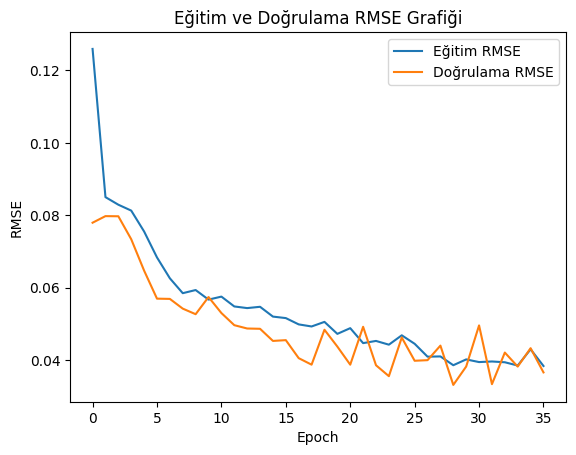

In [41]:
# RMSE hata grafiğini göster
plt.plot(np.sqrt(history.history['loss']), label='Eğitim RMSE')
plt.plot(np.sqrt(history.history['val_loss']), label='Doğrulama RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Eğitim ve Doğrulama RMSE Grafiği')
plt.legend()
plt.show()

### Prediction

In [42]:
# Gelecek tahminleri yap
future_predictions = []
last_sequence = X[-1]  # Son zaman serisi örneğini al

for _ in range(7 * 24):  # 7 gün * 24 saat
    next_pred = model.predict(last_sequence.reshape(1, time_step, X.shape[2]))
    future_predictions.append(next_pred[0, 0])
    # Yeni tahmini ekle ve son sequence'i güncelle
    last_sequence = np.append(last_sequence[1:], next_pred[0, 0])
    last_sequence = last_sequence.reshape(time_step, X.shape[2])

# Gelecek tahminleri orijinal ölçeğe geri dönüştür
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Tahminleri görüntüle
future_dates = pd.date_range(start=grouped_data['transition_date'].iloc[-1] + pd.Timedelta(hours=1), periods=7 * 24, freq='H')
plt.plot(future_dates, future_predictions, label='7 Günlük Tahmin')
plt.xlabel('Tarih')
plt.ylabel('Yolcu Sayısı')
plt.title('Önümüzdeki 7 Günün Saatlik Yolcu Sayısı Tahmini')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


ValueError: cannot reshape array of size 408 into shape (12,37)

## Eski Kodlar

In [ ]:
# Hyperparameter settings
epochs = 40
batch_size = 64
learning_rate = 0.0001

In [ ]:
from tensorflow.keras.layers import Input, GRU, LSTM, Dropout, Dense

In [ ]:
# Model 1: İlk GRU modeli (tanh varsayılan aktivasyon ile)
input_layer_1 = Input(shape=(X_train.shape[1], X_train.shape[2]))
x1 = GRU(32, return_sequences=True)(input_layer_1)
x1 = Dropout(0.3)(x1)
x1 = GRU(16)(x1)
x1 = Dropout(0.3)(x1)
output_layer_1 = Dense(168, activation='linear')(x1)

model_1 = Model(inputs=input_layer_1, outputs=output_layer_1)
model_1.compile(optimizer=Adam(learning_rate=learning_rate), loss='huber_loss')


In [ ]:
# Model 2: ReLU aktivasyon fonksiyonu ile GRU modeli
input_layer_2 = Input(shape=(X_train.shape[1], X_train.shape[2]))
x2 = GRU(32, activation='relu', return_sequences=True)(input_layer_2)
x2 = Dropout(0.3)(x2)
x2 = GRU(16, activation='relu')(x2)
x2 = Dropout(0.3)(x2)
output_layer_2 = Dense(168, activation='linear')(x2)

model_2 = Model(inputs=input_layer_2, outputs=output_layer_2)
model_2.compile(optimizer=Adam(learning_rate=learning_rate), loss='huber_loss')


In [ ]:
# Model 3: İlk LSTM modeli
input_layer_3 = Input(shape=(X_train.shape[1], X_train.shape[2]))
x3 = LSTM(64, return_sequences=True)(input_layer_3)
x3 = Dropout(0.3)(x3)
x3 = LSTM(32)(x3)
x3 = Dropout(0.3)(x3)
output_layer_3 = Dense(168, activation='linear')(x3)

model_3 = Model(inputs=input_layer_3, outputs=output_layer_3)
model_3.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')


In [ ]:
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:

# Model 1 eğitimi
history_1 = model_1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])


In [ ]:

# Model 2 eğitimi
history_2 = model_2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])


In [ ]:

# Model 3 eğitimi
history_3 = model_3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])


In [ ]:
# Test sonuçlarını değerlendirme
y_test_pred_1 = model_1.predict(X_test)
y_test_pred_2 = model_2.predict(X_test)
y_test_pred_3 = model_3.predict(X_test)

# RMSE hesaplama
test_rmse_1 = np.sqrt(mean_squared_error(y_test.flatten(), y_test_pred_1.flatten()))
test_rmse_2 = np.sqrt(mean_squared_error(y_test.flatten(), y_test_pred_2.flatten()))
test_rmse_3 = np.sqrt(mean_squared_error(y_test.flatten(), y_test_pred_3.flatten()))

print("Model 1 (GRU, varsayılan aktivasyon) Test Seti RMSE:", test_rmse_1)
print("Model 2 (GRU, ReLU aktivasyon) Test Seti RMSE:", test_rmse_2)
print("Model 3 (LSTM) Test Seti RMSE:", test_rmse_3)

In [ ]:
def plot_results_one_station_seven_days(actual, predicted, title, station_index=2, num_days=1):
    """Plots the actual and predicted values for one station for seven days.

    Args:
        actual: The actual values.
        predicted: The predicted values.
        title: The title of the plot.
        station_index: The index of the station to plot.
        num_days: The number of days to plot.
    """

    plt.figure(figsize=(12, 6))

    # Get data for the specified station and number of days
    actual_station = actual[station_index, :num_days * 168]
    predicted_station = predicted[station_index, :num_days * 168]

    plt.plot(actual_station, label="Actual", marker='o')
    plt.plot(predicted_station, label="Predicted", marker='x')
    plt.title(f"{title} - Station {station_index + 1}")
    plt.xlabel("Hours (Over 7 Days)")
    plt.ylabel("Number of Passengers")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming y_test and y_test_pred are your actual and predicted values
# and they have shape (num_stations, num_hours)
plot_results_one_station_seven_days(y_test, y_test_pred, "Model Evaluation on Test Set (Hourly Predictions)")

In [ ]:
#EOF

In [ ]:
#checkpoint = ModelCheckpoint('/kaggle/working/model_checkpoint.h5.keras', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
#model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])

In [ ]:
# Load the best model
#model.load_weights('/kaggle/working/model_checkpoint.h5.keras')

In [ ]:
# Make predictions on the test set
#predictions = model.predict(X_test)



```
# @title Varsayılan başlık metni
# Define LSTM model with Bidirectional LSTM layers
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = LSTM(64, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
x = LSTM(32)(x)
x = Dropout(0.3)(x)
output_layer = Dense(168, activation='linear')(x)  # Predicting 168 hourly values

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on test data with RMSE
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_test_pred.flatten()))
print("RMSE on Test Set:", test_rmse)
```
Epoch 1/15
634/634 [==============================] - 78s 118ms/step - loss: 6141.9287 - val_loss: 6013.4131
Epoch 2/15
634/634 [==============================] - 72s 114ms/step - loss: 5807.7456 - val_loss: 5875.2275
Epoch 3/15
634/634 [==============================] - 74s 117ms/step - loss: 5748.2134 - val_loss: 5854.4795
Epoch 4/15
634/634 [==============================] - 72s 114ms/step - loss: 5739.8740 - val_loss: 5851.9917
Epoch 5/15
634/634 [==============================] - 73s 116ms/step - loss: 5738.8394 - val_loss: 5851.5781
Epoch 6/15
634/634 [==============================] - 74s 117ms/step - loss: 5739.0259 - val_loss: 5851.5020
Epoch 7/15
634/634 [==============================] - 75s 118ms/step - loss: 5738.7144 - val_loss: 5851.4937
Epoch 8/15
634/634 [==============================] - 74s 116ms/step - loss: 5739.0679 - val_loss: 5851.4424
Epoch 9/15
634/634 [==============================] - 75s 119ms/step - loss: 5738.7021 - val_loss: 5851.4126
Epoch 10/15
634/634 [==============================] - 75s 118ms/step - loss: 5738.5425 - val_loss: 5851.4214
Epoch 11/15
634/634 [==============================] - 73s 115ms/step - loss: 5738.9507 - val_loss: 5851.4126
Epoch 12/15
634/634 [==============================] - 74s 117ms/step - loss: 5738.5063 - val_loss: 5844.7988
Epoch 13/15
634/634 [==============================] - 73s 116ms/step - loss: 5728.2959 - val_loss: 5839.5508
Epoch 14/15
634/634 [==============================] - 75s 119ms/step - loss: 5717.6406 - val_loss: 5831.8447
Epoch 15/15
634/634 [==============================] - 72s 113ms/step - loss: 5709.9351 - val_loss: 5803.7725

[94]
# Evaluate the model on test data with RMSE
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_test_pred.flatten()))
print("RMSE on Test Set:", test_rmse)
198/198 [==============================] - 7s 33ms/step
RMSE on Test Set: 75.64395273291461
